# Coffe Shop Sales

O dataset escolhido para este trabalho contém informações de transações referente à uma cafeteria 
ficticia que opera em três locais de Nova York.

Disponível em: https://www.kaggle.com/datasets/ahmedabbas757/coffee-sales

## Característiscas do Dataset

Vamos ver a descrição de cada propriedade do dataset:

- <b>transaction_id</b> : ID sequencial exclusivo que representa uma transação individual

- <b>transaction_date</b> : Data da transação (MM/DD/AA)

- <b>transaction_time</b> : Carimbo de data/hora da transação (HH:MM:SS)

- <b>transaction_qty</b> : Quantidade de itens vendidos

- <b>store_id</b> : ID exclusivo da cafeteria onde a transação ocorreu

- <b>store_location</b> : Localização da cafeteria onde a transação ocorreu

- <b>product_id</b> : ID exclusivo do produto vendido

- <b>unit_price</b> : Preço de varejo do produto vendido

- <b>product_category</b> : Descrição da categoria do produto

- <b>product_type</b> : Descrição do tipo de produto

- <b>product_detail</b> : Descrição dos detalhes do produto



#### Fazendo download do dataset

In [20]:
#https://www.kaggle.com/datasets/ahmedabbas757/coffee-sales
# import kagglehub

# # Defina o caminho onde deseja salvar o dataset
# destination_path = "/home/kelvin/"  # Altere para o caminho desejado

# # Baixe o dataset na pasta especificada
# path = kagglehub.dataset_download("ahmedabbas757/coffee-sales")

# print("Path to dataset files:", path)


### Interpretando o dataset

In [21]:
import pandas as pd
dataframe = pd.read_excel("Coffee Shop Sales.xlsx")

In [22]:
dataframe.head()

,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail
0,1,2023-01-01,07:06:11,2,5,Lower Manhattan,32,3.0,Coffee,Gourmet brewed coffee,Ethiopia Rg
1,2,2023-01-01,07:08:56,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg
2,3,2023-01-01,07:14:04,2,5,Lower Manhattan,59,4.5,Drinking Chocolate,Hot chocolate,Dark chocolate Lg
3,4,2023-01-01,07:20:24,1,5,Lower Manhattan,22,2.0,Coffee,Drip coffee,Our Old Time Diner Blend Sm
4,5,2023-01-01,07:22:41,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg


In [23]:
print(dataframe.shape)

(149116, 11)


### Tamanho do dataset

149116 registros e 11 colunas

### Vamos ver agora a proporção de cada Classe

In [24]:
columns = dataframe.columns.to_list()
for col in columns:
    print(dataframe[col].value_counts(normalize=True) * 100)
    print("-----------")

transaction_id
149456    0.000671
1         0.000671
2         0.000671
3         0.000671
4         0.000671
            ...   
32        0.000671
33        0.000671
34        0.000671
35        0.000671
36        0.000671
Name: proportion, Length: 149116, dtype: float64
-----------
transaction_date
2023-06-19    0.900641
2023-06-16    0.892594
2023-06-18    0.865098
2023-06-13    0.859063
2023-06-27    0.856380
                ...   
2023-02-06    0.327933
2023-01-30    0.322568
2023-01-28    0.315191
2023-01-31    0.309826
2023-01-29    0.307814
Name: proportion, Length: 181, dtype: float64
-----------
transaction_time
09:31:15    0.027495
08:15:41    0.026825
08:19:08    0.025484
11:40:03    0.024142
10:11:25    0.024142
              ...   
14:21:29    0.000671
14:37:47    0.000671
16:49:24    0.000671
17:07:57    0.000671
12:48:24    0.000671
Name: proportion, Length: 25762, dtype: float64
-----------
transaction_qty
1    58.450468
2    39.326430
3     2.198959
4     0.015424
8  

Destaque especial para a classe transaction_qty.

### Onde há valores nulos?

In [25]:
print(dataframe.isnull().sum())

transaction_id      0
transaction_date    0
transaction_time    0
transaction_qty     0
store_id            0
store_location      0
product_id          0
unit_price          0
product_category    0
product_type        0
product_detail      0
dtype: int64


### Normalização dos dados

In [26]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Tratando as datas
dataframe["transaction_date"] = pd.to_datetime(dataframe["transaction_date"])
dataframe["Year"] = dataframe["transaction_date"].dt.year
dataframe["Month"] = dataframe["transaction_date"].dt.month
dataframe["Day"] = dataframe["transaction_date"].dt.day
dataframe.drop(columns=["transaction_date"], inplace=True)

# Tratando os horários para o formato cíclico (Seno/Cosseno)
dataframe["transaction_time"] = pd.to_datetime(dataframe["transaction_time"], format="%H:%M:%S")
dataframe["hour"] = dataframe["transaction_time"].dt.hour
dataframe["sin_hour"] = np.sin(2 * np.pi * dataframe["hour"] / 24)
dataframe["cos_hour"] = np.cos(2 * np.pi * dataframe["hour"] / 24)

#Dropando as colunas auxiliares / descartaveis de horas
# dataframe.drop(columns=["transaction_time", "hour"], inplace=True)


# Criando um label (ID) para os valores em string
label_encoder = LabelEncoder()
dataframe["store_location"] = label_encoder.fit_transform(dataframe["store_location"])
dataframe["product_category"] = label_encoder.fit_transform(dataframe["product_category"])
dataframe["product_type"] = label_encoder.fit_transform(dataframe["product_type"])
dataframe["product_detail"] = label_encoder.fit_transform(dataframe["product_detail"])

In [27]:
dataframe.head()

,transaction_id,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail,Year,Month,Day,hour,sin_hour,cos_hour
0,1,1900-01-01 07:06:11,2,5,2,32,3.0,2,13,32,2023,1,1,7,0.965926,-0.258819
1,2,1900-01-01 07:08:56,2,5,2,57,3.1,8,4,71,2023,1,1,7,0.965926,-0.258819
2,3,1900-01-01 07:14:04,2,5,2,59,4.5,4,17,20,2023,1,1,7,0.965926,-0.258819
3,4,1900-01-01 07:20:24,1,5,2,22,2.0,2,10,60,2023,1,1,7,0.965926,-0.258819
4,5,1900-01-01 07:22:41,2,5,2,57,3.1,8,4,71,2023,1,1,7,0.965926,-0.258819


### O que vamos tentar prever?

Possíveis problemas:

- Existe um padrão de horário e quantidade de vendas em certas lojas?
- Há lojas ou produtos que têm padrões de vendas incomuns (outliers)?
- Os clientes seguem padrões de compras baseados em preço e quantidade?
- Há algum padrão nas transações?
- Existe um grupo de produtos frequentemente comprados juntos?


## Identificando Padrões
### Verificando os diferentes grupos de transações
Dado a categoria do produto, o tipo de produto, o preço unitário e a quantidade vendida, quais tipos de transações podemos identificar?

#### Padronizando os dados

In [28]:
from sklearn.preprocessing import StandardScaler

# Colunas a serem estudadas
features = ["product_category", "product_type", "unit_price", "transaction_qty"]
X = dataframe[features]

# Padronizando os dados
scaler = StandardScaler()
data_scaled = scaler.fit_transform(X)

#### KMEANS

In [29]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

kmeans = KMeans(n_clusters=3, random_state=0).fit(data_scaled)
kmeans.labels_

array([2, 2, 2, ..., 0, 0, 2], dtype=int32)

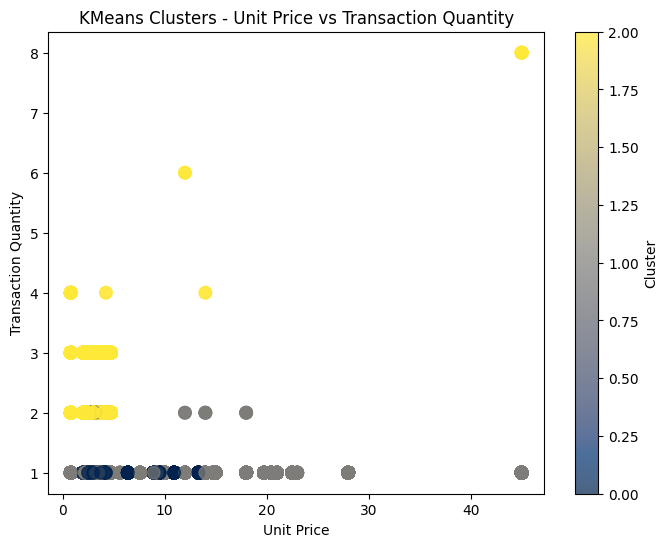

In [30]:
plt.figure(figsize=(8, 6))
# Selecionando duas colunas para plotar: unit_price e transaction_qty
scatter = plt.scatter(
  dataframe["unit_price"], 
  dataframe["transaction_qty"], 
  c=kmeans.labels_, 
  cmap='cividis', 
  s=80,
  alpha=0.7
)

plt.xlabel('Unit Price')
plt.ylabel('Transaction Quantity')
plt.title('KMeans Clusters - Unit Price vs Transaction Quantity')
plt.colorbar(scatter, label='Cluster')
plt.show()

Podemos observar no gráfico alguns outliers, como por exemplo uma transação de um produto com um valor alto em alta quantidade, o que não é comum!

### DBSCAN

In [31]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.15, min_samples=5)
clusters_dsbcan = dbscan.fit_predict(data_scaled)
unique_clusters = np.unique(clusters_dsbcan)
len(unique_clusters)

115

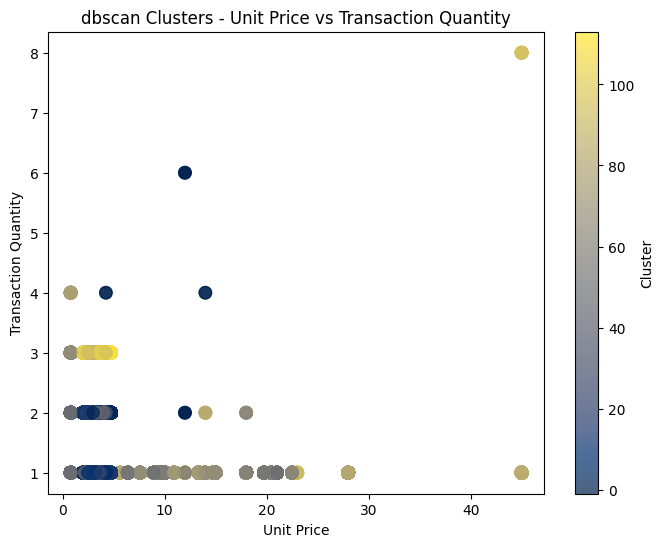

In [32]:
plt.figure(figsize=(8, 6))
# Selecionando duas colunas para plotar: unit_price e transaction_qty
scatter = plt.scatter(
  dataframe["unit_price"], 
  dataframe["transaction_qty"], 
  c=clusters_dsbcan, 
  cmap='cividis', 
  s=80,
  alpha=0.7
)

plt.xlabel('Unit Price')
plt.ylabel('Transaction Quantity')
plt.title('dbscan Clusters - Unit Price vs Transaction Quantity')
plt.colorbar(scatter, label='Cluster')
plt.show()

O dbscan identificou 115 tipo de clusters! Lembrando que o dataset possui um tamanho de 149 mil registros

Lembrando que, não foi feito nem um estudo para a definição do epsilon e do min_samples (Até o momento).

#### Hierárquico Aglomerativo

In [33]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.model_selection import train_test_split
from scipy.cluster.hierarchy import dendrogram, linkage
frac = 0.1

n_samples = int(len(data_scaled) * frac)
random_indices = np.random.choice(len(data_scaled), n_samples, replace=False)
data_sample = data_scaled[random_indices]

agglo_cluster = AgglomerativeClustering(3)
agglo_cluster.fit(data_sample)
agglo_cluster.labels_

array([0, 1, 1, ..., 0, 1, 1])

Eu tive alguns problemas para executar o algoritmo aglomerativo.

1 - Tive que pegar apenas 10% dos dados, pois acontecia um erro de "Não foi possível alocar 81GB"

2 - Outra abordagem foi tentar convertar de float64 para float32, porém, sem sucesso.

In [ ]:
# Calculando a matriz de ligação (Dendrograma)
#O método Ward tenta minimizar a variância dentro dos clusters ao fundi-los, 
# sendo útil para formar grupos compactos e homogêneos.
linked = linkage(data_sample, 'ward')

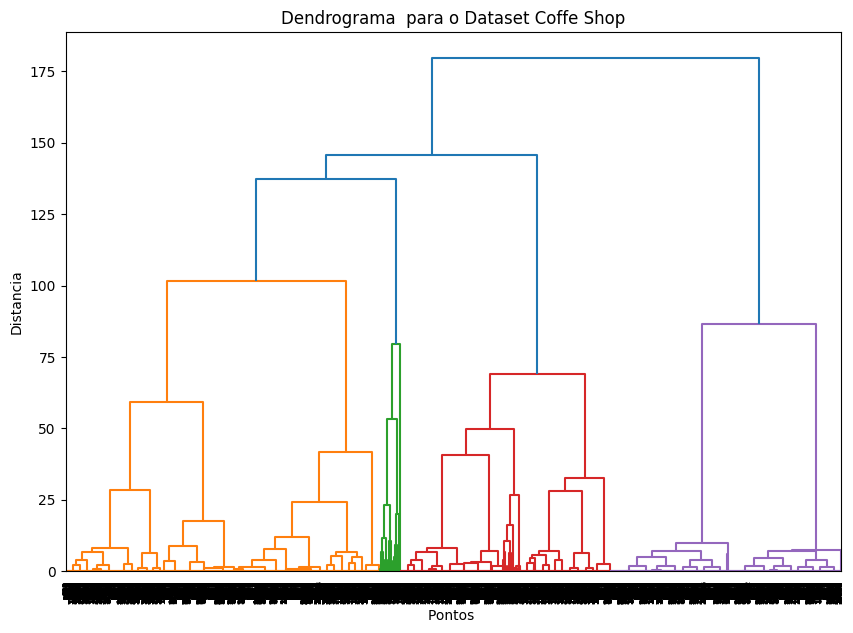

In [35]:
plt.figure(figsize=(10, 7))
dendrogram(linked,
            orientation='top',
            distance_sort='descending',
            show_leaf_counts=True)
plt.title("Dendrograma  para o Dataset Coffe Shop")
plt.xlabel("Pontos ")
plt.ylabel("Distancia")
plt.show()

Olhando para o dendrograma atual treinado com 3 clusters, no momento, a melhor divisão aparenta ser com 4 grupos.

### Resumo da primeira parte

Utilizando valores sem se preocupar com os hiperparâmetros, chegamos a diferentes conclusões para cada algoritmo.

Para o KMeans foi utilizado um K = 3, o que não nos diz muita coisa dado que a escolha foi completamente arbitrária.

Para o DBSCAN, o mesmo encontrou um total de 115 grupos com o epsilon de 0.15 e min_samples de 5. Ou seja, com estes parâmetros temos 115 tipos grupos de transações? Vamos ver se com a otimização isso ainda faz sentido. 

Já o hierárquico aglomerativo, com o número de clusters = 3 (Lembrando que foi utilizado o "ward"), podemos identificar um corte de 4 grupos. Novamente, faz sentido? Temos uma discrepância muito grande do dbscan para o aglomerativo. 

Vamos ver se na próxima parte os algoritmos irão convergir para um ponto comum. 

### Métricas que poderão ser utilizadas para a avaliação dos algoritmos


- Método do Cotovelo (Elbow Method): O ponto onde a inércia para de diminuir significativamente é o melhor número de clusters.
    - Utilizado no KMeans.

- Silhouette Score: Quão bem os pontos estão agrupados dentro do cluster versus quão longe estão dos outros clusters.
    - Utilizado no KMeans, DBscan e Hierárquico.



